# Simulate differential mean expression data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import statsmodels.api as sm
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', 100)
import pickle as pkl
import time
import string
from sklearn.datasets import make_spd_matrix
from statsmodels.stats.moment_helpers import cov2corr
import string

In [3]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [4]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.1.0-py3.10.egg')
import memento
import memento.simulate as simulate

In [5]:
data_path = '/data_volume/memento/simulation/inference/'

In [134]:
def convert_params_nb(mu, theta):
    """
    Convert mean/dispersion parameterization of a negative binomial to the ones scipy supports

    See https://en.wikipedia.org/wiki/Negative_binomial_distribution#Alternative_formulations
    """
    r = theta
    var = mu + 1 / r * mu ** 2
    p = (var - mu) / var
    return r, 1 - p

def convert_params_binom(mu, v):
    """
    Convert mean/dispersion parameterization of a negative binomial to the ones scipy supports

    See https://en.wikipedia.org/wiki/Negative_binomial_distribution#Alternative_formulations
    """
    p = 1-(v/mu)
    n = mu/p

    return n.astype(int), p

### Extract parameters from HBEC dataset

In [135]:
ifn_adata = sc.read('/data_volume/memento/hbec/' + 'HBEC_type_I_filtered_counts_deep.h5ad')
q=0.07

In [201]:
X = ifn_adata[
    (ifn_adata.obs['stim'] == 'control') & \
    (ifn_adata.obs['cell_type'] == 'basal')].X.toarray()

m = X.mean(axis=0)
v = X.var(axis=0)

df = pd.DataFrame(
    zip(m,v),
    index=ifn_adata.var.index,
    columns=['m', 'v'])

m_filtered = m[m > 0.01]
v_filtered = v[m > 0.01]

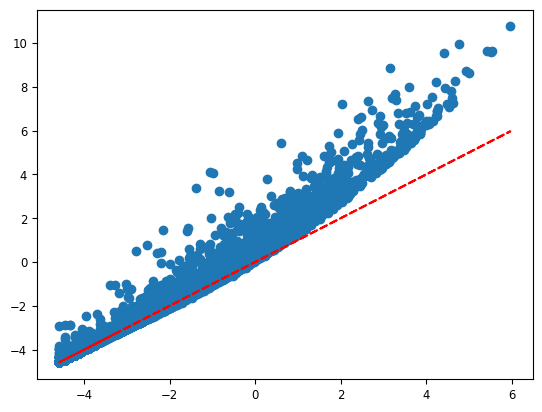

In [214]:
plt.scatter(
    np.log(m_filtered),
    np.log(v_filtered))
plt.plot(np.log(m_filtered), np.log(m_filtered), '--', color='red')

In [215]:
adata_1 = ifn_adata[(ifn_adata.obs['cell_type'] == 'ciliated') & (ifn_adata.obs['stim'] == 'control')]
adata_2 = ifn_adata[(ifn_adata.obs['cell_type'] == 'ciliated') & (ifn_adata.obs['stim'] == 'beta')]

x_param_1, z_param_1, Nc_1, good_idx_1 = simulate.extract_parameters(adata_1.X, q=q)
x_param_2, z_param_2, Nc_2, good_idx_2 = simulate.extract_parameters(adata_2.X, q=q)

### Simulate data

In [222]:
base_mean = z_param_1[0]
num_genes = base_mean.shape[0]
treatment_effect = np.zeros(num_genes)
treatment_effect[:100] = 1

means = np.zeros((4, num_genes))
means[0] = base_mean
means[1] = base_mean+treatment_effect
means[2] = base_mean + (0.2)
means[3] = base_mean + (0.2) + treatment_effect + (1)

# For Binom
variances = np.zeros((4, num_genes))
variances[0] = 0.9*means[0] 
variances[1] = 0.9*means[1] 
variances[2] = 0.9*means[2] 
variances[3] = 0.9*means[3] 

# For NB
dispersions = np.zeros((4, num_genes))
dispersions[0] = 0.001
dispersions[1] = 2
dispersions[2] = 0.001
dispersions[3] = 2

num_cells_per_group = 50
design = pd.DataFrame(
    [
        ('ctrl', 'A'),
        ('stim', 'A'),
        ('ctrl', 'B'),
        ('stim', 'B')], columns=['condition', 'group'])
design = pd.concat([design for i in range(num_cells_per_group)])
     

counts = stats.nbinom.rvs(
    *convert_params_nb(means, 1/dispersions), 
    size=(num_cells_per_group, 4, num_genes)).reshape(-1, num_genes)
# counts = stats.binom.rvs(
#     *convert_params_binom(means, variances), 
#     size=(num_cells_per_group, 4, num_genes)).reshape(-1, num_genes)
_, hyper_captured = simulate.capture_sampling(counts, q=q, process='hyper')
# hyper_captured = counts

trial = 0
expr_df = pd.DataFrame(counts)
grouped = pd.concat([design.reset_index(drop=True), expr_df], axis=1)
pseudobulks = grouped.groupby(['group', 'condition']).sum()
pseudobulks.index = [x+'-'+y for x, y in itertools.product(design['group'].unique(), design['condition'].unique())]

# anndata = sc.AnnData(sp.sparse.csr_matrix(hyper_captured))
# # anndata.var['is_null'] = null_de_genes
# anndata.obs = design.copy()

# anndata.write(data_path + 'means/anndata_{}.h5ad'.format(trial))
pseudobulks.T.to_csv(data_path + 'means/pseudobulks_{}.csv'.format(trial))